# Optimizer tweaks

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_08 import *

## Imagenette data

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
il = ImageItemList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

In [ ]:
bs=64

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=8)

In [ ]:
x,y = next(iter(valid_dl))

'n01440764'

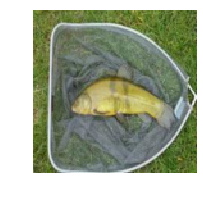

In [ ]:
show_image(x[0])
ll.train.y.processor.vocab[y[0]]

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.7493536540736, tensor(0.3982, device='cuda:0')]
valid: [1.7916949462890626, tensor(0.4040, device='cuda:0')]


## Momentum

### Base optimizer

In [ ]:
optim.Optimizer??

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, **defaults): super().__init__(params, defaults)
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None: p.data.add_(-pg['lr'], self.get_step(pg, p))
                    
    def get_step(self, pg, p): return p.grad.data

In [ ]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, opt_func=Optimizer, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [1.7247653947572514, tensor(0.4179, device='cuda:0')]
valid: [1.6834345703125, tensor(0.5140, device='cuda:0')]
CPU times: user 18.6 s, sys: 9.23 s, total: 27.8 s
Wall time: 28.9 s


### Implement momentum

In [ ]:
class StepFunc(): _defaults = {}

class MomentumStep(StepFunc):
    _defaults = dict(mom=0.9)

    def update(self, grad, pg):
        if not hasattr(self,'grad_avg'): self.grad_avg = grad.clone()
        else: self.grad_avg.mul_(pg['mom']).add_(grad)
        return self.grad_avg

In [ ]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, stats_func, **defaults):
        super().__init__(params, **{**stats_func._defaults, **defaults})
        self.stats_func = stats_func

    def get_state(self, p):
        # First time this param seen - create a stats obj for it and put it in `state`
        if p not in self.state: self.state[p] = self.stats_func()
        return self.state[p]
    
    def get_step(self, pg, p):
        # PyTorch will save anything stored in `state`; it's indexed by param
        stats = self.get_state(p)
        return stats.update(p.grad.data, pg)

In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=MomentumStep)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.05, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [1.7161379566077246, tensor(0.4115, device='cuda:0')]
valid: [1.34167041015625, tensor(0.5600, device='cuda:0')]
CPU times: user 20.3 s, sys: 9.75 s, total: 30.1 s
Wall time: 31.3 s


### Momentum experiments

In [ ]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5,0.7,0.9,0.99]

In [ ]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

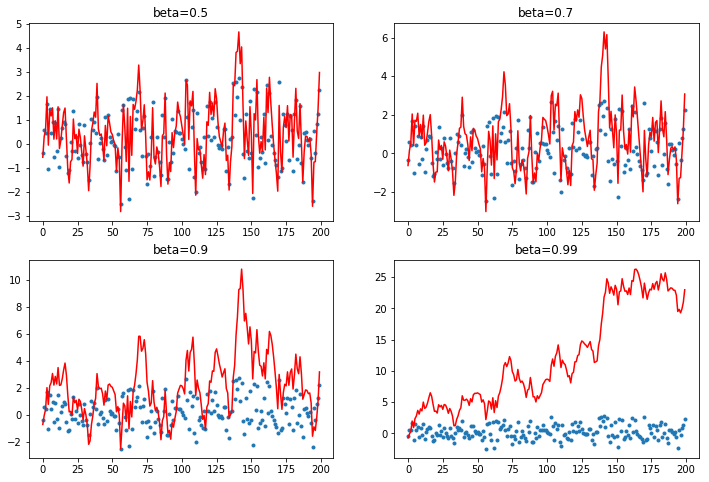

In [ ]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta * avg + yi
    return res,res
plot_mom(mom1)

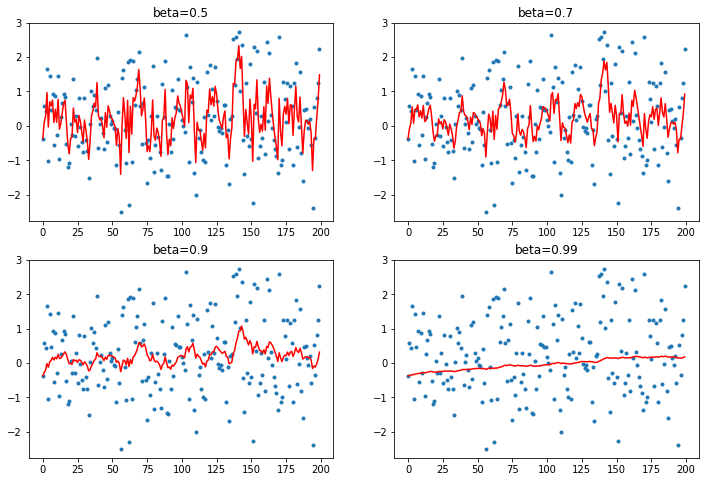

In [ ]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = beta * avg + (1-beta) * yi
    return avg, avg
plot_mom(mom2)

In [ ]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [ ]:
y[0]=0.5

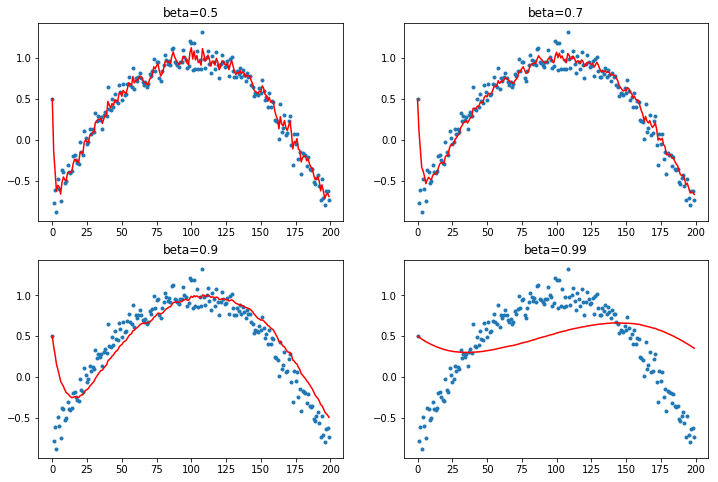

In [ ]:
plot_mom(mom2)

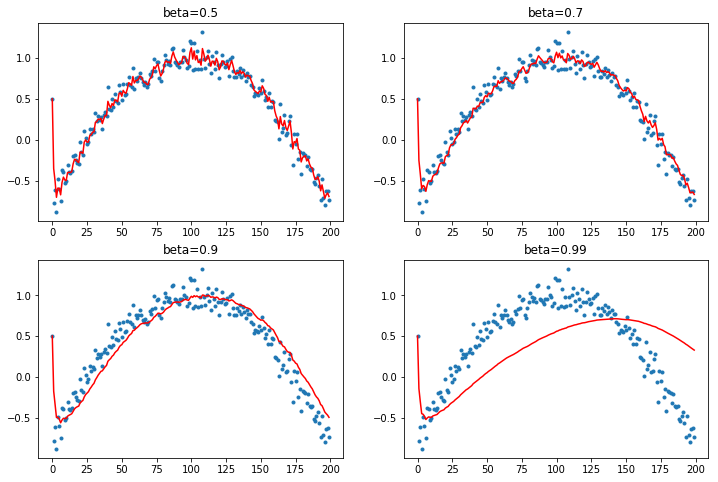

In [ ]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = beta * avg + (1-beta) * yi
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

### Adam and friends

In [ ]:
class GradStats(StepFunc):
    _defaults = dict(eps=1e-5, grad_mom=0., sqr_mom=0., grad_damp=1., sqr_damp=1.)

    def __init__(self, grad_damp=True, sqr_damp=True):
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
    
    def update(self, grad, pg):
        if not hasattr(self,'grad_avg'):
            if self.grad_damp: pg['grad_damp'] = 1-pg['grad_mom']
            if self.sqr_damp : pg['sqr_damp' ] = 1-pg['sqr_mom' ]
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(pg['grad_mom']).add_(pg['grad_damp'],grad)
        # Inplace version of:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp
        self.sqr_avg.mul_(pg['sqr_mom']).addcmul_(pg['sqr_damp'],grad,grad)
        # If grad_damp==1-grad_mom:
        # debias1 = 1 - self.grad_mom**self.iter
        debias1 = pg['grad_damp'] * (1 - pg['grad_mom']**self.iter) / (1-pg['grad_mom'])
        debias2 = pg['sqr_damp']  * (1 - pg['sqr_mom'] **self.iter) / (1-pg['sqr_mom'] )
        return self.grad_avg/debias1 / (self.sqr_avg/debias2 + pg['eps']).sqrt()

In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=GradStats, grad_mom=0.9, sqr_mom=0.99)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [1.9255110177214207, tensor(0.3659, device='cuda:0')]
valid: [1.661028076171875, tensor(0.5440, device='cuda:0')]
CPU times: user 15 s, sys: 6.57 s, total: 21.6 s
Wall time: 22.4 s


In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=GradStats, grad_mom=0.9, sqr_mom=0.99, eps=1)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.7152584898984025, tensor(0.4169, device='cuda:0')]
valid: [1.4491064453125, tensor(0.4980, device='cuda:0')]
train: [1.3134385421513883, tensor(0.5710, device='cuda:0')]
valid: [1.1914189453125, tensor(0.6220, device='cuda:0')]
CPU times: user 29.2 s, sys: 13.4 s, total: 42.6 s
Wall time: 44.1 s


### Channel stats

- [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) (LARS also uses weight statistics, not just gradient statistics. Can you add that to this class?)
- [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235) (Adafactor combines stats over multiple sets of axes)
- [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)

In [ ]:
class ChannelStats(StepFunc):
    _defaults = dict(eps=1e-5, grad_mom=0., sqr_mom=0., grad_damp=1., sqr_damp=1.)

    def __init__(self, grad_damp=True, sqr_damp=True):
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
    
    def update(self, grad, pg):
        if not hasattr(self,'grad_avg'):
            if self.grad_damp: pg['grad_damp'] = 1-pg['grad_mom']
            if self.sqr_damp : pg['sqr_damp' ] = 1-pg['sqr_mom' ]
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(pg['grad_mom']).add_(pg['grad_damp'],grad)
        # Inplace version of:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp
        sqr_avg = self.sqr_avg.mul(pg['sqr_mom']).addcmul(pg['sqr_damp'],grad,grad)
        # If grad_damp==1-grad_mom:
        # debias1 = 1 - self.grad_mom**self.iter
        debias1 = pg['grad_damp'] * (1 - pg['grad_mom']**self.iter) / (1-pg['grad_mom'])
        debias2 = pg['sqr_damp']  * (1 - pg['sqr_mom'] **self.iter) / (1-pg['sqr_mom'] )
        res = self.grad_avg/debias1 / (sqr_avg/debias2 + pg['eps']).sqrt()
        self.sqr_avg = sqr_avg
        if grad.ndim==4: self.sqr_avg = sqr_avg.mean((2,3), keepdim=True)
        return res

In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=ChannelStats, grad_mom=0.9, sqr_mom=0.99)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.8369722290891113, tensor(0.3843, device='cuda:0')]
valid: [1.5790758056640626, tensor(0.5080, device='cuda:0')]
train: [1.4694396679172483, tensor(0.5705, device='cuda:0')]
valid: [1.3140919189453124, tensor(0.6440, device='cuda:0')]
CPU times: user 29.5 s, sys: 13.4 s, total: 42.9 s
Wall time: 44.4 s


In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.0003, 0.003), sched_cos(0.003, 0.0001)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, 
                          opt_func=opt_func, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
%time run.fit(8, learn)

train: [2.0465602339266327, tensor(0.2978, device='cuda:0')]
valid: [1.87085693359375, tensor(0.3860, device='cuda:0')]
train: [1.7571355560241197, tensor(0.4774, device='cuda:0')]
valid: [1.6373489990234376, tensor(0.5320, device='cuda:0')]
train: [1.4089630775457578, tensor(0.6075, device='cuda:0')]
valid: [1.267303466796875, tensor(0.6380, device='cuda:0')]
train: [1.1028064924819683, tensor(0.6849, device='cuda:0')]
valid: [0.9245093383789063, tensor(0.7200, device='cuda:0')]
train: [0.8426244613531487, tensor(0.7493, device='cuda:0')]
valid: [0.912294189453125, tensor(0.7240, device='cuda:0')]
train: [0.5694787031516597, tensor(0.8471, device='cuda:0')]
valid: [0.791373046875, tensor(0.7620, device='cuda:0')]
train: [0.2749703183772491, tensor(0.9553, device='cuda:0')]
valid: [0.7418658447265625, tensor(0.7680, device='cuda:0')]
train: [0.14857977335630915, tensor(0.9906, device='cuda:0')]
valid: [0.7429068603515625, tensor(0.7800, device='cuda:0')]
CPU times: user 1min 57s, sys: 

## Imagewoof

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160)

In [ ]:
il = ImageItemList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=8)

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, 
                          opt_func=opt_func, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
%time run.fit(8, learn)

train: [2.22257815009234, tensor(0.1825, device='cuda:0')]
valid: [2.167277587890625, tensor(0.2100, device='cuda:0')]
train: [2.062793737202907, tensor(0.2545, device='cuda:0')]
valid: [2.08421923828125, tensor(0.2620, device='cuda:0')]
train: [1.9195324732515657, tensor(0.3234, device='cuda:0')]
valid: [1.9659266357421874, tensor(0.2860, device='cuda:0')]
train: [1.7392146850409507, tensor(0.3967, device='cuda:0')]
valid: [1.8077734375, tensor(0.3940, device='cuda:0')]
train: [1.5121722940420748, tensor(0.4786, device='cuda:0')]
valid: [1.75608251953125, tensor(0.3640, device='cuda:0')]
train: [1.1262822969778785, tensor(0.6434, device='cuda:0')]
valid: [1.7213623046875, tensor(0.4000, device='cuda:0')]
train: [0.5707876077715995, tensor(0.8875, device='cuda:0')]
valid: [1.8371231689453125, tensor(0.3760, device='cuda:0')]
train: [0.2813672282750522, tensor(0.9824, device='cuda:0')]
valid: [1.862028076171875, tensor(0.3740, device='cuda:0')]
CPU times: user 1min 53s, sys: 51.2 s, tot

## Export

In [ ]:
!python notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
